In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import emachine as EM

In [2]:
np.random.seed(1)

In [3]:
s0 = np.loadtxt('s_test.dat')
l,n = s0.shape
print(l,n)

1076 38


In [4]:
# find conserved variables
fc = 0.9
l,n = s0.shape
frequency = [max(np.unique(s0[:,i], return_counts=True)[1]) for i in range(n)]
cols_conserved = [i for i in range(n) if frequency[i]/float(l) > fc]
print(cols_conserved)

[8, 18, 33, 36]


In [5]:
cols_active = np.delete(np.arange(0,n),cols_conserved)
print(len(cols_active))

34


In [6]:
# load predicted w from train set
#w_mle = np.loadtxt('w_mle.dat')
w_ple = np.loadtxt('w_ple.dat')
w_em = np.loadtxt('w_em.dat')
print(w_em.shape)

(741,)


In [7]:
# random missing position
#for n_hidden in [2,4,6,8,10,12,14]:
#for n_hidden in [10]:
#for n_hidden in [2]:
n_hidden = 14

# every possibilities of configurations of hiddens
s_hidden_possibles = np.asarray(list(itertools.product([1.0, -1.0], repeat=n_hidden)))
n_possibles = s_hidden_possibles.shape[0]
#print(n_possibles)

s_hidden_all = np.array([])
s_recover_all1 = np.array([])
s_recover_all2 = np.array([])
# consider a specific sample t:
acc = np.zeros((3,l))
for t in range(l):
    s = s0[t].copy()
    #print(s)

    #hidden = np.random.choice(np.arange(17,n),n_hidden,replace=False)
    #hidden = np.random.choice(np.arange(0,n),n_hidden,replace=False)

    hidden = np.random.choice(cols_active,n_hidden,replace=False)       
    #print(hidden)

    s_possibles = np.tile(s,(n_possibles,1))
    s_possibles[:,hidden] = s_hidden_possibles
    #print(s_possibles)

    # calculate energy of each possible configuration
    ops = EM.operators(s_possibles)

    """
    #----------------------------------------------
    # w from MLE
    energy0 = -ops.dot(w_mle)    
    # select the best sequence that maximize probability
    s_hidden_recover0 = s_hidden_possibles[np.argmin(energy0)]
    #print(s_hidden_recover)
    acc[0,t] = np.sum((s[hidden] == s_hidden_recover0))
    #print(acc[t])
    """
    #----------------------------------------------
    # w from PLE
    energy1 = -ops.dot(w_ple)    
    s_hidden_recover1 = s_hidden_possibles[np.argmin(energy1)]
    acc[1,t] = np.sum((s[hidden] == s_hidden_recover1))

    #----------------------------------------------
    # w from EM
    energy2 = -ops.dot(w_em)
    s_hidden_recover2 = s_hidden_possibles[np.argmin(energy2)]
    acc[2,t] = np.sum((s[hidden] == s_hidden_recover2))

    # 2019.11.25: for raster plot
    # hidden
    s[hidden] = 0
    s_hidden_all = np.vstack([s_hidden_all,s[np.newaxis,:]]) if s_hidden_all.shape[0]>0 else s

    # recover by PLE
    s_recover1 = s.copy()
    s_recover1[hidden] = s_hidden_recover1
    s_recover_all1 = np.vstack([s_recover_all1,s_recover1[np.newaxis,:]]) \
                    if s_recover_all1.shape[0]>0 else s_recover1        

    # recover by EM
    s_recover2 = s.copy()
    s_recover2[hidden] = s_hidden_recover2
    s_recover_all2 = np.vstack([s_recover_all2,s_recover2[np.newaxis,:]]) \
                    if s_recover_all2.shape[0]>0 else s_recover2

acc_av = acc.sum(axis=1)/(n_hidden*l) 
print('accuracy of MLE, PLE, EM:',n_hidden,acc_av)

accuracy of MLE, PLE, EM: 14 [0.         0.64013542 0.84081253]


In [8]:
np.savetxt('s_hidden_nh%s.dat'%n_hidden,s_hidden_all,fmt='%i')
np.savetxt('s_recover_PLE_nh%s.dat'%n_hidden,s_recover_all1,fmt='%i')
np.savetxt('s_recover_EM_nh%s.dat'%n_hidden,s_recover_all2,fmt='%i')

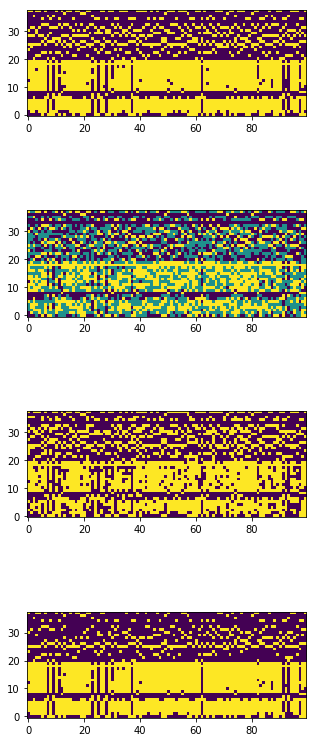

In [10]:
nx,ny = 1,4
nfig = nx*ny
fig, ax = plt.subplots(ny,nx,figsize=(nx*4.5,ny*2.9))

tcut = 100

#plt.title('raster')
ax[0].imshow(s0.T[:,:tcut],origin='lower')
ax[1].imshow(s_hidden_all.T[:,:tcut],origin='lower')
ax[2].imshow(s_recover_all1.T[:,:tcut],origin='lower')
ax[3].imshow(s_recover_all2.T[:,:tcut],origin='lower')

#plt.xlabel('samples')
#plt.ylabel('variable index')
plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()